[You can map via NBViewer](https://nbviewer.jupyter.org/github/taakuu/Coursera_Capstone/blob/main/Week4-5_The_Battle_of_Neighborhoods/Week5-The-Battle-of-Neighborhoods.ipynb)

# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

-------------------

## Introduction: Business Problem <a name="introduction"></a>

### Backgroud

As COVID-19 has spread around the world for more than a year, vaccination is showing signs of convergence. However, there are still many unclear points about COVID-19 infection.

According to statistics, East Asians have a fairly low number of COVID-19 infections. It cannot be concluded that the cause has yet to be determined, whether it is due to genetic characteristics, many people already have immunity, or cultural differences.
It is strange that the number of infected people is smaller than in the West in the big city of Tokyo, which has a murderous crowded train commuter.

People infected with COVID-19 vary from region to region. It cannot be said that there are many infected people because of the large population. The risk of COVID-19 infection varies depending on what kind of city you live in or stay in.

_Note: For convenience, this document refers to the cities and wards of Tokyo as Borough._

### Problem

The problem is to answer the question of what kind of city is the one with many COVID-19 infections.

There are various factors that cause a city with many infected people, such as many overseas travelers, many foreigners, and many bars where clusters are likely to occur.
The purpose of this survey is to focus on the number of foreign residents and the number of bars to gain insight into the causal relationship with the number of people infected with COVID-19.

Sample use case:
- As a person planning to move to Tokyo, find out what kind of city has the same characteristics as a city with few infected people.
- As a visitor planning a trip to Tokyo, I would like to find a safe city with the same characteristics as a city with few infected people and enjoy eating and drinking.

It would be greatly appreciated if the causative factors could be clarified by solving this problem.

### Target Audience

- Those who want to move to or stay in Tokyo
- Those who want to know which city is relatively safe against infection

-------------------

## Data <a name="data"></a>

### Data Requirements

Based on definition of our problem, factors that will influence our decission are:
* the number of foreign residents in Tokyo
* the number of COVID-19 test positives in Tokyo
* the number of existing bars in the neighborhood (any type of bar)

### Data Collection

Following data sources will be needed to extract/generate the required information:

* The number of Foreign residents in Tokyo will be obtained from the following site:

  - Source: [_"2-4  FOREIGN RESIDENTS BY DISTRICT AND NATIONALITY ( 2019 )" in "TOKYO STATISTICAL YEARBOOK"_ ](https://www.toukei.metro.tokyo.lg.jp/tnenkan/2018/tn18q3i002.htmhttps://www.toukei.metro.tokyo.lg.jp/tnenkan/2018/tn18q3i002.htm)
    - by [_Statistics Division, Bureau of General Affairs, Tokyo Metropolitan Government_](https://www.toukei.metro.tokyo.lg.jp/homepage/ENGLISH.htm)
  - The data is as of 2019.
  - The data is aggregated by Borough, which means ward and city in Tokyo.
  
  > Foreign residents here mean foreign nationals who are registered according to the Basic Resident Registration Act.
    
* The number of COVID-19 test positive in Tokyo will be obtained from the following site:

  - Source: 
      - [_COVID-19 The information website by Tokyo Metropolitan Government_](https://stopcovid19.metro.tokyo.lg.jp/en)
      - [_Tokyo COVID-19 Task Force website (https://github.com/tokyo-metropolitan-gov)_](https://github.com/tokyo-metropolitan-gov/covid19/blob/development/docs/en/README.md)
  - The data is as of the day before yesterday.
  - The data is aggregated by Borough, which means ward and city in Tokyo.

* The list of Special wards and districts in Tokyo

  - Source:
      - [_Wikipedia: Special wards of Tokyo_](https://en.wikipedia.org/wiki/Special_wards_of_Tokyo)
      
* The number of bars and their type and location in every neighborhood will be obtained using **Foursquare API**


--------------------------------

Import some libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium==0.5.0
import folium # map rendering library

from bs4 import BeautifulSoup
print('Libraries imported.')

Libraries imported.


### Postal code in Tokyo (not used)

In [2]:
!wget -q -O 'ken_all_rome.zip' "https://www.post.japanpost.jp/zipcode/dl/roman/ken_all_rome.zip?200708"
print('Data downloaded!')

Data downloaded!


In [3]:
!rm KEN_ALL_ROME.CSV 
!unzip 'ken_all_rome.zip'
print('Unzip completed')

Archive:  ken_all_rome.zip
  inflating: KEN_ALL_ROME.CSV        
Unzip completed


In [4]:
zipcode = pd.read_csv('KEN_ALL_ROME.CSV', header=None, encoding='shift_jis')
print(zipcode.shape)
#zipcode.head()

(124433, 7)


In [5]:
zipcode = zipcode[zipcode[4]=='TOKYO TO'].reset_index(drop=True)
print(zipcode.shape)
#zipcode.head()

(4005, 7)


In [6]:
zipcode.drop(index=zipcode.index[[0]],
             columns=zipcode.columns[[1,4]], inplace=True)
zipcode.reset_index(inplace=True, drop=True)
zipcode.columns = ['Postal_code', 'Borough_J', 'Town_J', 'Borough', 'Town']
zipcode.head(10)

,Postal_code,Borough_J,Town_J,Borough,Town
0,1020072,千代田区,飯田橋,CHIYODA KU,IIDABASHI
1,1020082,千代田区,一番町,CHIYODA KU,ICHIBANCHO
2,1010032,千代田区,岩本町,CHIYODA KU,IWAMOTOCHO
3,1010047,千代田区,内神田,CHIYODA KU,UCHIKANDA
4,1000011,千代田区,内幸町,CHIYODA KU,UCHISAIWAICHO
5,1000004,千代田区,大手町 （次のビルを除く）,CHIYODA KU,OTEMACHI (TSUGINOBIRUONOZOKU)
6,1006890,千代田区,大手町 ＪＡビル（地階・階層不明）,CHIYODA KU,OTEMACHI JIEIEIBIRU(CHIKAI.KAISOFUM
7,1006801,千代田区,大手町 ＪＡビル（１階）,CHIYODA KU,OTEMACHI JIEIEIBIRU(1-KAI)
8,1006802,千代田区,大手町 ＪＡビル（２階）,CHIYODA KU,OTEMACHI JIEIEIBIRU(2-KAI)
9,1006803,千代田区,大手町 ＪＡビル（３階）,CHIYODA KU,OTEMACHI JIEIEIBIRU(3-KAI)


We cannot use Japanes postal code for Neighborhoods because too many postal code in Tokyo.

### Foreign residents in Tokyo

In [7]:
!wget -q -O '2018_foreign_residents.csv' "https://www.toukei.metro.tokyo.lg.jp/tnenkan/2018/tn18qv020400.csv"
print("Data downloaded")

Data downloaded


In [8]:
foreign = pd.read_csv('2018_foreign_residents.csv', encoding='shift_jis', skiprows=10)
print(foreign.shape)
foreign.head()

(66, 21)


,11,年次\n(平成),Year,階層\nコード,地域\nコード,地域,district,総数 Total,中国 China,韓国 Rep. of Korea,ベトナム Vietnam,フィリピン Philippines,ネパール Nepal,台湾 Taiwan,アメリカ U.S.A.,イ ン ド India,ミャンマー Myanmar,タイ Thailand,その他 Others,Unnamed: 19,Unnamed: 20
0,12,27,2015,0,13000,総数,Tokyo-to,417442,172769,94010,14645,28681,14355,…,16097,8730,5627,7154,55374,NaN,NaN
1,13,28,2016,0,13000,総数,Tokyo-to,449042,185982,93309,22131,29575,18412,…,16411,9475,7044,7370,59333,NaN,NaN
2,14,29,2017,0,13000,総数,Tokyo-to,486346,185883,88755,27762,30761,22660,17281,16939,10354,8249,7651,70051,NaN,NaN
3,15,30,2018,0,13000,総数,Tokyo-to,521500,199949,90438,32334,32089,26157,18568,17578,11153,9719,7958,75557,NaN,NaN
4,16,31,2019,0,13000,総数,Tokyo-to,551683,213767,92418,36227,33219,27290,19726,18508,12130,10395,8101,79902,NaN,NaN


In [9]:
foreign = foreign[foreign['階層\nコード'] > 1]
foreign.reset_index(inplace=True, drop=True)
print(foreign.shape)
#foreign

(57, 21)


In [10]:
foreign.drop(columns=foreign.columns[[0,1,2,3,5,19,20]], inplace=True)
foreign.columns = ["Municipal_code","Borough","FR_total","FR_China","FR_Rep_of_Korea","FR_Vietnam","FR_Philippines","FR_Nepal","FR_Taiwan","FR_USA","FR_India","FR_Myanmar","FR_Thailand","FR_Others"]
print(foreign.shape)
#foreign

(57, 14)


In [11]:
# Drop subtotal rows
foreign = foreign[~foreign.Borough.str.startswith('All')]
foreign.reset_index(inplace=True, drop=True)
print(foreign.shape)
#foreign

(57, 14)


In [12]:
# For merge purpose, add one to the code of '*-shicho' in order to change to the code of '*-mura'.
foreign['Municipal_code'] = foreign['Municipal_code'].apply(lambda x: x + 1 if x in {13360,13380,13400,13420} else x)
print(foreign.shape)
#foreign

(57, 14)


In [13]:
# Split Borough name into Borough and suffix 
Borough_kind = foreign['Borough'].str.split('-', expand=True)
Borough_kind.rename(columns={0: 'Borough', 1: 'Borough_suffix'}, inplace=True)
Borough_kind.head()

,Borough,Borough_suffix
0,Chiyoda,ku
1,Chuo,ku
2,Minato,ku
3,Shinjuku,ku
4,Bunkyo,ku


In [14]:
foreign['Borough'] = Borough_kind['Borough']
foreign.insert(2, 'Borough_suffix', Borough_kind['Borough_suffix'])
print(foreign.shape)
#foreign

(57, 15)


In [15]:
# Strip heading and trailing blanks in all strings
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

foreign = trim_all_columns(foreign)
#foreign

In [16]:
# Replace '-' cell with 0
foreign.replace('-', '0', inplace=True)
foreign

,Municipal_code,Borough,Borough_suffix,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others
0,13101,Chiyoda,ku,2996,1250,455,76,64,24,194,210,79,16,46,582
1,13102,Chuo,ku,7651,3266,1401,192,153,95,385,391,275,38,89,1366
2,13103,Minato,ku,20057,3962,3461,144,1027,107,756,3257,649,56,191,6447
3,13104,Shinjuku,ku,43068,14153,10221,3484,747,3517,1884,1033,246,2218,735,4830
4,13105,Bunkyo,ku,10808,4646,1658,927,223,364,509,329,107,317,192,1536
5,13106,Taito,ku,15433,6489,3118,824,785,688,503,253,713,134,334,1592
6,13107,Sumida,ku,12645,5874,1966,679,1349,320,401,183,140,75,388,1270
7,13108,Koto,ku,29472,14783,4557,1030,1585,583,703,467,2065,436,366,2897
8,13109,Shinagawa,ku,13042,4317,2426,547,798,712,600,607,402,292,196,2145
9,13110,Meguro,ku,9102,1836,1498,202,537,252,469,979,198,54,165,2912


### COVID19 Test positives in Tokyo

In [17]:
!wget -O 'covid19_tokyo.json' 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/patient.json'
print("Download completed")

--2021-02-28 23:55:15--  https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/patient.json
raw.githubusercontent.com (raw.githubusercontent.com) をDNSに問いあわせています... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 13804 (13K) [text/plain]
`covid19_tokyo.json' に保存中

covid19_tokyo.json  100%[===================>]  13.48K  --.-KB/s 時間 0s         

2021-02-28 23:55:15 (50.4 MB/s) - `covid19_tokyo.json' へ保存完了 [13804/13804]

Download completed


In [18]:
import json
fd = open('covid19_tokyo.json', mode='r')
d = json.load(fd)
covid_json_date = d['datasets']['date']
print("Date of covid19 patient.json :", covid_json_date)
s_target = json.dumps(d['datasets']['data'])
covid = pd.read_json(s_target)
print(covid.shape)
covid.head()

Date of covid19 patient.json : 2021/2/27
(65, 5)


,code,area,label,ruby,count
0,131016.0,特別区,千代田区,ちよだく,601
1,131024.0,特別区,中央区,ちゅうおうく,1828
2,131032.0,特別区,港区,みなとく,3792
3,131041.0,特別区,新宿区,しんじゅくく,6551
4,131059.0,特別区,文京区,ぶんきょうく,1688


In [19]:
covid.dropna(subset=['code'],inplace=True)
covid.drop(columns=covid.columns[[1,3]], inplace=True)
covid['code'] = (covid['code'] / 10).astype(int)
covid.columns = ["Municipal_code","Borough_J","COVID_positive"]
print(covid.shape)
covid

(62, 3)


,Municipal_code,Borough_J,COVID_positive
0,13101,千代田区,601
1,13102,中央区,1828
2,13103,港区,3792
3,13104,新宿区,6551
4,13105,文京区,1688
5,13106,台東区,2069
6,13107,墨田区,2150
7,13108,江東区,3575
8,13109,品川区,3251
9,13110,目黒区,3053


### Merge Foreign residents and COVID19 Test positives in Tokyo

In [20]:
#covid_foreign = pd.merge(covid, foreign, on='Municipal_code', how='outer', indicator=True)
covid_foreign = pd.merge(covid, foreign, on='Municipal_code')
print(covid_foreign.shape)
covid_foreign.head()

(57, 17)


,Municipal_code,Borough_J,COVID_positive,Borough,Borough_suffix,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others
0,13101,千代田区,601,Chiyoda,ku,2996,1250,455,76,64,24,194,210,79,16,46,582
1,13102,中央区,1828,Chuo,ku,7651,3266,1401,192,153,95,385,391,275,38,89,1366
2,13103,港区,3792,Minato,ku,20057,3962,3461,144,1027,107,756,3257,649,56,191,6447
3,13104,新宿区,6551,Shinjuku,ku,43068,14153,10221,3484,747,3517,1884,1033,246,2218,735,4830
4,13105,文京区,1688,Bunkyo,ku,10808,4646,1658,927,223,364,509,329,107,317,192,1536


### Add Longitude and Latitude in COVID positive and Foreign residents dataFrame 

In [21]:
from functools import partial
from geopy.geocoders import Nominatim 
geolocator = Nominatim(user_agent="tokyo_explorer")
_geocode = partial(geolocator.geocode, language="en")
#f_geocode = lambda query, **kw: _geocode("%s, Tokyo, Japan" % query, **kw)
covid_foreign['Address'] = covid_foreign['Borough'] + ', Tokyo, Japan'
#f_get_lon_lat = lambda x: (x.latitude, x.longitude)
f_get_lon_lat = lambda x: (None, None) if x is None else (x.latitude, x.longitude)
covid_foreign['temp']= covid_foreign['Address'].apply(_geocode).apply(f_get_lon_lat)    
covid_foreign[['Latitude', 'Longitude']] = covid_foreign['temp'].apply(pd.Series)

covid_foreign.drop(['temp','Address'], axis=1, inplace=True)
covid_foreign

,Municipal_code,Borough_J,COVID_positive,Borough,Borough_suffix,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others,Latitude,Longitude
0,13101,千代田区,601,Chiyoda,ku,2996,1250,455,76,64,24,194,210,79,16,46,582,35.693810,139.753216
1,13102,中央区,1828,Chuo,ku,7651,3266,1401,192,153,95,385,391,275,38,89,1366,35.666255,139.775565
2,13103,港区,3792,Minato,ku,20057,3962,3461,144,1027,107,756,3257,649,56,191,6447,35.643227,139.740055
3,13104,新宿区,6551,Shinjuku,ku,43068,14153,10221,3484,747,3517,1884,1033,246,2218,735,4830,35.693763,139.703632
4,13105,文京区,1688,Bunkyo,ku,10808,4646,1658,927,223,364,509,329,107,317,192,1536,35.718810,139.744732
5,13106,台東区,2069,Taito,ku,15433,6489,3118,824,785,688,503,253,713,134,334,1592,35.717450,139.790859
6,13107,墨田区,2150,Sumida,ku,12645,5874,1966,679,1349,320,401,183,140,75,388,1270,35.700429,139.805017
7,13108,江東区,3575,Koto,ku,29472,14783,4557,1030,1585,583,703,467,2065,436,366,2897,35.649154,139.812790
8,13109,品川区,3251,Shinagawa,ku,13042,4317,2426,547,798,712,600,607,402,292,196,2145,35.599252,139.738910
9,13110,目黒区,3053,Meguro,ku,9102,1836,1498,202,537,252,469,979,198,54,165,2912,35.621250,139.688014


### Get special wards and major districts in Tokyo

In [22]:
!pip install lxml
import lxml

In [23]:
wards = pd.read_html('https://en.wikipedia.org/wiki/Special_wards_of_Tokyo')[3]
wards.head()

,No.,Flag,Name,Kanji,Population(as of October 2016,Density(/km2),Area(km2),Major districts
0,01,NaN,Chiyoda,千代田区,59441,5100,11.66,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,..."
1,02,NaN,Chūō,中央区,147620,14460,10.21,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb..."
2,03,NaN,Minato,港区,248071,12180,20.37,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong..."
3,04,NaN,Shinjuku,新宿区,339211,18620,18.22,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich..."
4,05,NaN,Bunkyō,文京区,223389,19790,11.29,"Hongō, Yayoi, Hakusan"


In [24]:
wards.drop(index=wards.index[[-1]],
           columns=wards.columns[[0,1]], inplace=True)
wards.reset_index(inplace=True, drop=True)
wards.columns = ["Borough","Borough_J","Population","Density","Area","Neighborhoods"]
print(wards.shape)
#wards

(23, 6)


In [25]:
# Remove umlaut
import unicodedata
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

wards['Borough'] = wards['Borough'].apply(lambda x: strip_accents(x))
wards['Neighborhoods'] = wards['Neighborhoods'].apply(lambda x: strip_accents(x))

#wards.head(10)

In [26]:
wards["Neighborhoods"]=wards["Neighborhoods"].str.split(",")
neighborhoods =wards.explode("Neighborhoods").reset_index(drop=True)
neighborhoods.drop(['Borough_J','Population', 'Density', 'Area'], axis=1, inplace=True)
neighborhoods.rename(columns={'Neighborhoods': 'Neighborhood'}, inplace=True)
neighborhoods['Neighborhood'] = neighborhoods['Neighborhood'].str.strip()
neighborhoods.reset_index(inplace=True, drop=True)
print(neighborhoods.shape)
neighborhoods.head()

(106, 2)


,Borough,Neighborhood
0,Chiyoda,Nagatacho
1,Chiyoda,Kasumigaseki
2,Chiyoda,Otemachi
3,Chiyoda,Marunouchi
4,Chiyoda,Akihabara


### Merge Tokyo special ward area and the others Borough

In [27]:
neighborhoods = neighborhoods.merge(Borough_kind, how="outer", indicator=False)
neighborhoods.loc[neighborhoods['Neighborhood'].isnull(), 'Address'] = neighborhoods['Borough'] + ', Tokyo, Japan'
neighborhoods.loc[neighborhoods['Neighborhood'].notnull(), 'Address'] = neighborhoods['Neighborhood'] + ', ' + neighborhoods['Borough'] + ', Tokyo, Japan'
neighborhoods.loc[neighborhoods['Neighborhood'].isnull(), 'Neighborhood'] = neighborhoods['Borough']
neighborhoods.reset_index(inplace=True, drop=True)
print(neighborhoods.shape)
neighborhoods.head()

(140, 4)


,Borough,Neighborhood,Borough_suffix,Address
0,Chiyoda,Nagatacho,ku,"Nagatacho, Chiyoda, Tokyo, Japan"
1,Chiyoda,Kasumigaseki,ku,"Kasumigaseki, Chiyoda, Tokyo, Japan"
2,Chiyoda,Otemachi,ku,"Otemachi, Chiyoda, Tokyo, Japan"
3,Chiyoda,Marunouchi,ku,"Marunouchi, Chiyoda, Tokyo, Japan"
4,Chiyoda,Akihabara,ku,"Akihabara, Chiyoda, Tokyo, Japan"


In [28]:
def get_coordinates(address):
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        lat = location.latitude
        lon = location.longitude
        return [lat, lon]
    except:
        return [None, None]

address = 'Tokyo, Tokyo, Japan'
address = 'Kanda, Chiyoda, Tokyo'
tokyo_center = get_coordinates(address)
print('Coordinate of {}: {}'.format(address, tokyo_center))

Coordinate of Kanda, Chiyoda, Tokyo: [35.6917842, 139.770917]


In [29]:
def get_address(latitude, longitude):
    try:
        geolocator = Nominatim(user_agent="my_reverse")
        location = geolocator.reverse("{}, {}".format(latitude, longitude), language="en")
        address = location.address
        return address
    except:
        return None

addr = get_address(tokyo_center[0], tokyo_center[1])
print('Reverse geocoding check')
print('-----------------------')
print('Address of [{}, {}] is: "{}"'.format(tokyo_center[0], tokyo_center[1], addr))

Reverse geocoding check
-----------------------
Address of [35.6917842, 139.770917] is: "Kanda, Kanda Fureai-dori, 2-chome, Kajicho, Kanda, Chiyoda, Tokyo, 101-0044, Japan"


In [30]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 57 boroughs and 140 neighborhoods.


-----------------------------------------

### Add Longitude and Latitude in neighborhoods 

In [31]:
from functools import partial
from geopy.geocoders import Nominatim 
geolocator = Nominatim(user_agent="tokyo_explorer")
_geocode = partial(geolocator.geocode, language="en")
#f_geocode = lambda query, **kw: _geocode("%s, Tokyo, Japan" % query, **kw)
#neighborhoods['Address'] = neighborhoods['Neighborhood'] + ', ' + neighborhoods['Borough'] + ', Tokyo, Japan'
#f_get_lon_lat = lambda x: (x.latitude, x.longitude)
f_get_lon_lat = lambda x: (None, None) if x is None else (x.latitude, x.longitude)
neighborhoods['temp']= neighborhoods['Address'].apply(_geocode).apply(f_get_lon_lat)    
neighborhoods[['Latitude', 'Longitude']] = neighborhoods['temp'].apply(pd.Series)

neighborhoods.drop(['temp'], axis=1, inplace=True)
neighborhoods.head()

,Borough,Neighborhood,Borough_suffix,Address,Latitude,Longitude
0,Chiyoda,Nagatacho,ku,"Nagatacho, Chiyoda, Tokyo, Japan",35.675618,139.743469
1,Chiyoda,Kasumigaseki,ku,"Kasumigaseki, Chiyoda, Tokyo, Japan",35.674054,139.750972
2,Chiyoda,Otemachi,ku,"Otemachi, Chiyoda, Tokyo, Japan",35.684631,139.766466
3,Chiyoda,Marunouchi,ku,"Marunouchi, Chiyoda, Tokyo, Japan",35.680656,139.765222
4,Chiyoda,Akihabara,ku,"Akihabara, Chiyoda, Tokyo, Japan",35.698768,139.774255


----------------------------

### Explore Dataset

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent tokyo_explorer, as shown below.

In [32]:
# Select the address where is the center of Tokyo Prefecture in order to view whole Tokyo Prefecture
address = 'Tsutsujigaoka, Tokyo, Japan'

geolocator = Nominatim(user_agent="tokyo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Tsutsujigaoka, Tokyo, Japan are 35.6580672, 139.5752432.


#### View neighborhoods in Tokyo

In [33]:
# create map of Tokyo using latitude and longitude values
map_tokyo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo)  
    
map_tokyo

In [34]:
#neighborhoods.groupby("Borough").count()

#### View COVID19 positive in Tokyo

In [35]:
address = 'Tsutsujigaoka, Tokyo, Japan'

geolocator = Nominatim(user_agent="tokyo_wards_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Tsutsujigaoka, Tokyo, Japan are 35.6580672, 139.5752432.


In [36]:
from folium.features import DivIcon

title = 'COVID19 positive in Tokyo as of ' + covid_json_date
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(title) 

map_tokyo_covid = folium.Map(location=[latitude, longitude], zoom_start=11)
map_tokyo_covid.get_root().html.add_child(folium.Element(title_html))

covid_max = covid_foreign['COVID_positive'].max()

# add markers to map
for lat, lng, label, covid in zip(covid_foreign['Latitude'], covid_foreign['Longitude'], covid_foreign['Borough'], covid_foreign['COVID_positive']):
    label = folium.Popup("{}:{}".format(label,covid), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=(covid * 80)/covid_max,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_tokyo_covid)
    '''
    folium.map.Marker(
        [lat + 0.5, lng - 1.6],
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 24pt">1000 %d</div>' % covid,
        )
    ).add_to(map_tokyo_covid)
    '''
map_tokyo_covid

#### View Foreign residents in Tokyo

In [37]:
map_tokyo_foreign = folium.Map(location=[latitude, longitude], zoom_start=11)

covid_max = covid_foreign['FR_total'].max()

# add markers to map
for lat, lng, label, covid in zip(covid_foreign['Latitude'], covid_foreign['Longitude'], covid_foreign['Borough'], covid_foreign['FR_total']):
    label = folium.Popup("{}:{}".format(label,covid), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=(covid * 80)/covid_max,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo_foreign)  
    
map_tokyo_foreign

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on bars in each neighborhood.

We're interested in venues in 'food' category, but only those that are proper bars - coffe shops, pizza places, bakeries etc. are not direct competitors so we don't care about those. So we will include in out list only venues that have 'bar' in category name, and we'll make sure to detect and include all the subcategories of specific 'bar' category, as we need info on bars in the neighborhood.

In [38]:
#### Define Foursquare Credentials and Version

In [39]:
CLIENT_ID = 'VZRJ0J3TDQVHLIIMN0BGUB2MJS2GR3U1ZOM3WRNJXYZUDPG2' # your Foursquare ID
CLIENT_SECRET = 'LWP0JDR5PJZJFFLUAVVJ4J0ITIT3SWJV3VGOIEKXS121T2XK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VZRJ0J3TDQVHLIIMN0BGUB2MJS2GR3U1ZOM3WRNJXYZUDPG2
CLIENT_SECRET:LWP0JDR5PJZJFFLUAVVJ4J0ITIT3SWJV3VGOIEKXS121T2XK



Get the first neighborhood's name.

In [40]:
neighborhoods.loc[0, 'Neighborhood']

'Nagatacho'

Get the neighborhood's latitude and longitude values.

In [41]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Nagatacho are 35.675618, 139.7434685.


In [42]:
#### Now, let's get the top 100 venues that are in Nagatacho within a radius of 500 meters.

In [43]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 300 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VZRJ0J3TDQVHLIIMN0BGUB2MJS2GR3U1ZOM3WRNJXYZUDPG2&client_secret=LWP0JDR5PJZJFFLUAVVJ4J0ITIT3SWJV3VGOIEKXS121T2XK&v=20180605&ll=35.675618,139.7434685&radius=300&limit=100'

Send the GET request and examine the resutls

In [44]:
results = requests.get(url).json()
#results

From the Foursquare lab in the previous module, we know that all the information is in the items key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [45]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [46]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Nagatacho Kurosawa (永田町 黒澤),Japanese Restaurant,35.674699,139.741737
1,The Capitol Hotel Tokyu (ザ・キャピトルホテル東急),Hotel,35.673927,139.741019
2,Tully's Coffee,Coffee Shop,35.674594,139.743007
3,All Day Dining Origami (オールデイダイニング ORIGAMI),Restaurant,35.673815,139.741104
4,HOSHIGAOKA / STAR HILL (星ヶ岡),Chinese Restaurant,35.673953,139.740998


And how many venues were returned by Foursquare?

In [47]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
print('{} unique categories'.format(nearby_venues['categories'].value_counts().shape[0]))
nearby_venues['categories'].value_counts()

24 venues were returned by Foursquare.
18 unique categories


Convenience Store           3
Coffee Shop                 3
Japanese Restaurant         2
Platform                    2
Restaurant                  1
Hotel                       1
Hotel Bar                   1
Donburi Restaurant          1
ATM                         1
Bus Stop                    1
Bike Rental / Bike Share    1
Food Court                  1
Post Office                 1
Intersection                1
Chinese Restaurant          1
Café                        1
Tea Room                    1
Metro Station               1
Name: categories, dtype: int64

### Explore Neighborhoods in Tokyo

In [48]:
def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        print(name, ',', borough)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Create a dataFrame for Tokyo Venues

Now write the code to run the above function on each neighborhood and create a new dataframe.

In [49]:
tokyo_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                               boroughs=neighborhoods['Borough'],
                               latitudes=neighborhoods['Latitude'],
                               longitudes=neighborhoods['Longitude']
                              )
print('Completed')

Nagatacho , Chiyoda
Kasumigaseki , Chiyoda
Otemachi , Chiyoda
Marunouchi , Chiyoda
Akihabara , Chiyoda
Yurakucho , Chiyoda
Iidabashi , Chiyoda
Kanda , Chiyoda
Nihonbashi , Chuo
Kayabacho , Chuo
Ginza , Chuo
Tsukiji , Chuo
Hatchobori , Chuo
Shinkawa , Chuo
Tsukishima , Chuo
Kachidoki , Chuo
Tsukuda , Chuo
Odaiba , Minato
Shinbashi , Minato
Hamamatsucho , Minato
Mita , Minato
Roppongi , Minato
Toranomon , Minato
Aoyama , Minato
Azabu , Minato
Akasaka , Minato
Shinjuku , Shinjuku
Takadanobaba , Shinjuku
Okubo , Shinjuku
Kagurazaka , Shinjuku
Ichigaya , Shinjuku
Yotsuya , Shinjuku
Sendagaya , Shinjuku
Yoyogi , Shinjuku
Hongo , Bunkyo
Yayoi , Bunkyo
Hakusan , Bunkyo
Ueno , Taito
Asakusa , Taito
Kinshicho , Sumida
Morishita , Sumida
Ryogoku , Sumida
Kiba , Koto
Ariake , Koto
Kameido , Koto
Toyocho , Koto
Monzennakacho , Koto
Fukagawa , Koto
Kiyosumi , Koto
Shirakawa , Koto
Etchujima , Koto
Sunamachi , Koto
Aomi , Koto
Shinagawa , Shinagawa
Gotanda , Shinagawa
Osaki , Shinagawa
Hatanodai , Sh

Let's check the size of the resulting dataframe

In [50]:
print(tokyo_venues.shape)
tokyo_venues.head()

(8061, 8)


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Nagatacho,Chiyoda,35.675618,139.743469,Nagatacho Kurosawa (永田町 黒澤),35.674699,139.741737,Japanese Restaurant
1,Nagatacho,Chiyoda,35.675618,139.743469,The Capitol Hotel Tokyu (ザ・キャピトルホテル東急),35.673927,139.741019,Hotel
2,Nagatacho,Chiyoda,35.675618,139.743469,All Day Dining Origami (オールデイダイニング ORIGAMI),35.673815,139.741104,Restaurant
3,Nagatacho,Chiyoda,35.675618,139.743469,Tully's Coffee,35.674594,139.743007,Coffee Shop
4,Nagatacho,Chiyoda,35.675618,139.743469,Shinamen Hashigo (支那麺 はしご),35.672184,139.741576,Ramen Restaurant


In [51]:
tokyo_venues.groupby('Neighborhood').count().head()

,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Akabane,100,100,100,100,100,100,100
Akasaka,100,100,100,100,100,100,100
Akihabara,100,100,100,100,100,100,100
Akiruno,4,4,4,4,4,4,4
Akishima,16,16,16,16,16,16,16


In [52]:
tokyo_venues['Neighborhood'].value_counts().head(10)

Daikanyama       100
Aobadai          100
Roppongi         100
Ginza            100
Shibuya          100
Jiyugaoka        100
Hamamatsucho     100
Shimokitazawa    100
Gotanda          100
Omori            100
Name: Neighborhood, dtype: int64

Let's check how many venues were returned for each neighborhood

In [53]:
print('There are {} uniques categories.'.format(len(tokyo_venues['Venue Category'].unique())))

There are 357 uniques categories.


In [54]:
#tokyo_venues['Venue Category'].unique()

Let's find out how many unique categories can be curated from all the returned venues

### Create a dataFrame which venue category has "Bar" 

In [55]:
# Create a dataFrame of "* Bar"

tokyo_venues_bar = tokyo_venues[tokyo_venues['Venue Category'].str.contains('Bar')].reset_index(drop=True)
#Tokyo_Venues_bar.index = np.arange(1, len(tokyo_venues_bar) + 1)
tokyo_venues_bar.head()

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Nagatacho,Chiyoda,35.675618,139.743469,The Capitol Bar (ザ・キャピトル バー),35.673980,139.740965,Hotel Bar
1,Nagatacho,Chiyoda,35.675618,139.743469,Bar Blossom (バー・ブロッサム),35.672685,139.739614,Bar
2,Kasumigaseki,Chiyoda,35.674054,139.750972,PRONTO IL BAR,35.671203,139.747148,Bar
3,Otemachi,Chiyoda,35.684631,139.766466,Dining & Bar TENQOO,35.684307,139.767926,Bar
4,Otemachi,Chiyoda,35.684631,139.766466,RIGOLETTO WINE AND BAR,35.682459,139.764502,Wine Bar


In [56]:
print('There are {} uniques categories.'.format(len(tokyo_venues_bar['Venue Category'].unique())))
tokyo_venues_bar['Venue Category'].value_counts()

There are 14 uniques categories.


Sake Bar              336
Bar                    96
Beer Bar               58
Wine Bar               31
Cocktail Bar           14
Hotel Bar              10
Juice Bar               9
Hookah Bar              7
Whisky Bar              7
Sports Bar              5
Dive Bar                1
Rooftop Bar             1
Salon / Barbershop      1
Champagne Bar           1
Name: Venue Category, dtype: int64

### Create a dataFrame of Neighborhood versus the number of Bar

In [57]:
tokyo_venues_bar_count = tokyo_venues_bar.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Bar')].count())
#tokyo_venues_bar_count

In [58]:
tokyo_venues_bar_count  = tokyo_venues_bar_count.to_frame().reset_index()
tokyo_venues_bar_count.columns = ['Neighborhood', 'Number of Bar']
print(tokyo_venues_bar_count.shape)
tokyo_venues_bar_count.head()

(99, 2)


,Neighborhood,Number of Bar
0,Akabane,19
1,Akasaka,4
2,Akihabara,17
3,Aobadai,5
4,Aoto,4


-----------------------------

## Methodology <a name="methodology"></a>

In the previous Data section, the following data frame were created to be investigated:

  - `tokyo_venues_bar` : list of bar
    - Neighborhood (key)
    - Borough (key)
    - Neighborhood Latitude
    - Neighborhood Longitude
    - Venue
    - Venue Latitude
    - Venue Longitude
    - Venue Category

  - `covid_foreign` : list of Borough with COVID positive and Foreign Residents
    - Municipal_code
    - Borough_J
    - COVID_positive
    - Borough (key)
    - Borough_suffix
    - FR_total
    - FR_China
    - FR_Rep_of_Korea
    - FR_Vietnam
    - FR_Philippines
    - FR_Nepal
    - FR_Taiwan
    - FR_USA
    - FR_India
    - FR_Myanmar
    - FR_Thailand
    - FR_Others
    - Latitude
    - Longitude

Now, let's proceed with the following two major analysis steps:

  - analysis neighborhood bars
  - analysis COVID positive, Foreign Residents and bars per Borough

### 1. Analysis Neighborhood bars

The purpose of this step is to investigate what kind of neighborhood belongs to the Borough.

  - Use only `tokyo_venues_bar`
  - Use **k-means** to cluster the Neighborhoods bar. 
  - Use KElbowVisualizer to determine the optimal k value
  - Visualize the resulting Neighborhood bar clusters
  - List each Neighborhood bar per cluster to investigate

### 2. Analysis COVID positive, Foreign Residents and bars per Borough

The purpose of this step is to investigate what Borough clusters are susceptible to COVID-19 infection.

  - Aggregate each type of bar by Borough by using `tokyo_venues_bar`
  - Merge it with `covid_foreign`
  - Use sklearn.preprocessing.StandardScaler to normalize over the standard deviation
  - Use **k-means** to cluster the Borough
  - Use KElbowVisualizer to determine the optimal k value
  - Visualize the resulting Borough clusters
  - List each Borough per cluster to investigate


----------------

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of bars in every area candidate**:

### Analyze Each Neighborhood

In [59]:
# one hot encoding
tokyo_onehot = pd.get_dummies(tokyo_venues_bar[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tokyo_onehot['Neighborhood'] = tokyo_venues_bar['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot = tokyo_onehot[fixed_columns]

print(tokyo_onehot.shape)
tokyo_onehot.head()

(577, 15)


,Neighborhood,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
0,Nagatacho,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,Nagatacho,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Kasumigaseki,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Otemachi,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Otemachi,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [60]:
tokyo_grouped = tokyo_onehot.groupby('Neighborhood').mean().reset_index()
tokyo_grouped.head()

,Neighborhood,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
0,Akabane,0.105263,0.052632,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.842105,0.0,0.0,0.000000,0.000000
1,Akasaka,0.250000,0.250000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.0,0.0,0.000000,0.000000
2,Akihabara,0.058824,0.058824,0.0,0.0,0.0,0.0,0.0,0.117647,0.0,0.647059,0.0,0.0,0.058824,0.058824
3,Aobadai,0.200000,0.200000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.600000,0.0,0.0,0.000000,0.000000
4,Aoto,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.000000,0.000000


Let's confirm the new size

In [61]:
tokyo_grouped.shape

(99, 15)

Let's print each neighborhood along with the top 5 most common venues

In [62]:
"""
num_top_venues = 5

for hood in tokyo_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = tokyo_grouped[tokyo_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
"""

'\nnum_top_venues = 5\n\nfor hood in tokyo_grouped[\'Neighborhood\']:\n    print("----"+hood+"----")\n    temp = tokyo_grouped[tokyo_grouped[\'Neighborhood\'] == hood].T.reset_index()\n    temp.columns = [\'venue\',\'freq\']\n    temp = temp.iloc[1:]\n    temp[\'freq\'] = temp[\'freq\'].astype(float)\n    temp = temp.round({\'freq\': 2})\n    print(temp.sort_values(\'freq\', ascending=False).reset_index(drop=True).head(num_top_venues))\n    print(\'\n\')\n'

Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [64]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tokyo_grouped['Neighborhood']

for ind in np.arange(tokyo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tokyo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akabane,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar
1,Akasaka,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar
2,Akihabara,Sake Bar,Juice Bar,Bar,Beer Bar,Whisky Bar,Wine Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar
3,Aobadai,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar
4,Aoto,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar


### Cluster Neighborhoods

To analyze which neighborhood of Tokyo is good to open a new bar, I will use a K-means clustering: a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.

So the first step is identify the best “K” using a famous analytical approach: the elbow method.

Let's see:


In [65]:
!pip install yellowbrick

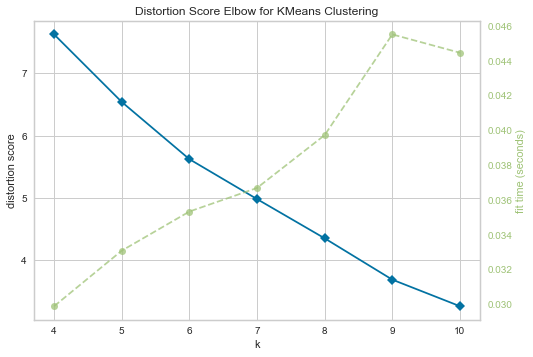

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [66]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

tokyo_part_clustering = tokyo_grouped.drop('Neighborhood', 1)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,11), locate_elbow=False)

visualizer.fit(tokyo_part_clustering)        # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

From the plot up here, it is difficult to select the best k value.

Run _k_-means to cluster the neighborhood into 5 clusters.

In [67]:
# set number of clusters
kclusters = 5

tokyo_grouped_clustering = tokyo_grouped.drop('Neighborhood', 1)

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering)
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 3, 3, 1, 1, 1, 1, 3, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [68]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tokyo_merged = neighborhoods.copy()

# merge neighborhoods with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
tokyo_merged = tokyo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
tokyo_merged = tokyo_merged.join(tokyo_venues_bar_count.set_index('Neighborhood'), on='Neighborhood')

tokyo_merged.head() # check the last columns!

,Borough,Neighborhood,Borough_suffix,Address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Number of Bar
0,Chiyoda,Nagatacho,ku,"Nagatacho, Chiyoda, Tokyo, Japan",35.675618,139.743469,2.0,Bar,Hotel Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Juice Bar,Rooftop Bar,Sake Bar,2.0
1,Chiyoda,Kasumigaseki,ku,"Kasumigaseki, Chiyoda, Tokyo, Japan",35.674054,139.750972,2.0,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,1.0
2,Chiyoda,Otemachi,ku,"Otemachi, Chiyoda, Tokyo, Japan",35.684631,139.766466,0.0,Wine Bar,Bar,Beer Bar,Cocktail Bar,Sake Bar,Champagne Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,6.0
3,Chiyoda,Marunouchi,ku,"Marunouchi, Chiyoda, Tokyo, Japan",35.680656,139.765222,0.0,Beer Bar,Wine Bar,Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,2.0
4,Chiyoda,Akihabara,ku,"Akihabara, Chiyoda, Tokyo, Japan",35.698768,139.774255,3.0,Sake Bar,Juice Bar,Bar,Beer Bar,Whisky Bar,Wine Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,17.0


#### View Neighborhood clusters

Finally, let's visualize the resulting clusters


In [69]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, b, n, cluster, bar in zip(tokyo_merged['Latitude'], 
                                        tokyo_merged['Longitude'], 
                                        tokyo_merged['Borough'], 
                                        tokyo_merged['Neighborhood'],
                                        tokyo_merged['Cluster Labels'], 
                                        tokyo_merged['Number of Bar']):
    if np.isnan(cluster):
        color = '#ffffff'
        str_cluster = 'NaN'
    else:
        color = rainbow[int(cluster) - 1]
        str_cluster = str(int(cluster) + 1)
    if np.isnan(bar):
        str_bar = '0'
    else:
        str_bar = str(int(bar))
    label = folium.Popup(str(n) + ',' + str(b) + ', Cluster:' + str_cluster + ', Bar:' + str_bar, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5 if np.isnan(bar) else int(bar)*3,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Neighborhood Clusters



Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.


#### Cluster 1

In [70]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 0, tokyo_merged.columns[[0,1,2] + list(range(6, tokyo_merged.shape[1]))]]

,Borough,Neighborhood,Borough_suffix,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Number of Bar
2,Chiyoda,Otemachi,ku,0.0,Wine Bar,Bar,Beer Bar,Cocktail Bar,Sake Bar,Champagne Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,6.0
3,Chiyoda,Marunouchi,ku,0.0,Beer Bar,Wine Bar,Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,2.0
5,Chiyoda,Yurakucho,ku,0.0,Hotel Bar,Bar,Beer Bar,Cocktail Bar,Sake Bar,Wine Bar,Champagne Bar,Dive Bar,Hookah Bar,Juice Bar,7.0
9,Chuo,Kayabacho,ku,0.0,Wine Bar,Bar,Sake Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,5.0
11,Chuo,Tsukiji,ku,0.0,Cocktail Bar,Juice Bar,Bar,Beer Bar,Champagne Bar,Dive Bar,Hookah Bar,Hotel Bar,Rooftop Bar,Sake Bar,2.0
13,Chuo,Shinkawa,ku,0.0,Wine Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,4.0
21,Minato,Roppongi,ku,0.0,Bar,Beer Bar,Hotel Bar,Cocktail Bar,Sake Bar,Whisky Bar,Wine Bar,Champagne Bar,Dive Bar,Hookah Bar,11.0
26,Shinjuku,Shinjuku,ku,0.0,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,2.0
33,Shinjuku,Yoyogi,ku,0.0,Bar,Beer Bar,Dive Bar,Hotel Bar,Sake Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Juice Bar,Rooftop Bar,8.0
55,Shinagawa,Osaki,ku,0.0,Beer Bar,Juice Bar,Sports Bar,Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Rooftop Bar,3.0


#### Cluster 2

In [71]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 1, tokyo_merged.columns[[0,1,2] + list(range(6, tokyo_merged.shape[1]))]]

,Borough,Neighborhood,Borough_suffix,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Number of Bar
14,Chuo,Tsukishima,ku,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,5.0
15,Chuo,Kachidoki,ku,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,1.0
16,Chuo,Tsukuda,ku,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,2.0
30,Shinjuku,Ichigaya,ku,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,3.0
32,Shinjuku,Sendagaya,ku,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,1.0
34,Bunkyo,Hongo,ku,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,2.0
35,Bunkyo,Yayoi,ku,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,1.0
36,Bunkyo,Hakusan,ku,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,1.0
37,Taito,Ueno,ku,1.0,Sake Bar,Cocktail Bar,Beer Bar,Juice Bar,Bar,Champagne Bar,Dive Bar,Hookah Bar,Hotel Bar,Rooftop Bar,16.0
39,Sumida,Kinshicho,ku,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,12.0


#### Cluster 3

In [72]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 2, tokyo_merged.columns[[0,1,2] + list(range(6, tokyo_merged.shape[1]))]]

,Borough,Neighborhood,Borough_suffix,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Number of Bar
0,Chiyoda,Nagatacho,ku,2.0,Bar,Hotel Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Juice Bar,Rooftop Bar,Sake Bar,2.0
1,Chiyoda,Kasumigaseki,ku,2.0,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,1.0
10,Chuo,Ginza,ku,2.0,Bar,Beer Bar,Whisky Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,5.0
17,Minato,Odaiba,ku,2.0,Bar,Sake Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,3.0
56,Shinagawa,Hatanodai,ku,2.0,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,1.0
71,Setagaya,Tamagawa,ku,2.0,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,1.0
122,Komae,Komae,shi,2.0,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,2.0


#### Cluster 4

In [73]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 3, tokyo_merged.columns[[0,1,2] + list(range(6, tokyo_merged.shape[1]))]]

,Borough,Neighborhood,Borough_suffix,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Number of Bar
4,Chiyoda,Akihabara,ku,3.0,Sake Bar,Juice Bar,Bar,Beer Bar,Whisky Bar,Wine Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,17.0
6,Chiyoda,Iidabashi,ku,3.0,Sake Bar,Bar,Beer Bar,Wine Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,6.0
7,Chiyoda,Kanda,ku,3.0,Sake Bar,Beer Bar,Bar,Wine Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,14.0
8,Chuo,Nihonbashi,ku,3.0,Sake Bar,Bar,Beer Bar,Cocktail Bar,Hotel Bar,Wine Bar,Champagne Bar,Dive Bar,Hookah Bar,Juice Bar,8.0
12,Chuo,Hatchobori,ku,3.0,Sake Bar,Wine Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,5.0
18,Minato,Shinbashi,ku,3.0,Sake Bar,Beer Bar,Juice Bar,Bar,Hotel Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Rooftop Bar,15.0
19,Minato,Hamamatsucho,ku,3.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,6.0
20,Minato,Mita,ku,3.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,5.0
22,Minato,Toranomon,ku,3.0,Sake Bar,Bar,Beer Bar,Rooftop Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,5.0
24,Minato,Azabu,ku,3.0,Sake Bar,Cocktail Bar,Wine Bar,Bar,Champagne Bar,Beer Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,10.0


#### Cluster 5

In [74]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 4, tokyo_merged.columns[[0,1,2] + list(range(6, tokyo_merged.shape[1]))]]

,Borough,Neighborhood,Borough_suffix,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Number of Bar
67,Ota,Den-en-chofu,ku,4.0,Salon / Barbershop,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,1.0


----------------------------------

### Analyze COVID positive, foreign residents and bars

In [75]:
# one hot encoding
tokyo_onehot_borough = pd.get_dummies(tokyo_venues_bar[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tokyo_onehot_borough['Borough'] = tokyo_venues_bar['Borough'] 

# move neighborhood column to the first column
fixed_columns = [tokyo_onehot_borough.columns[-1]] + list(tokyo_onehot_borough.columns[:-1])
tokyo_onehot_borough = tokyo_onehot_borough[fixed_columns]

print(tokyo_onehot_borough.shape)
tokyo_onehot_borough.head()

(577, 15)


,Borough,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
0,Chiyoda,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,Chiyoda,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Chiyoda,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Chiyoda,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Chiyoda,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [76]:
tokyo_bars_borough = tokyo_onehot_borough.groupby('Borough').sum().reset_index()
print(tokyo_bars_borough.shape)
tokyo_bars_borough.head()

(30, 15)


,Borough,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
0,Adachi,1,0,0,0,0,0,0,0,0,11,0,0,0,0
1,Arakawa,0,0,0,0,0,0,0,0,0,9,0,0,0,0
2,Bunkyo,0,0,0,0,0,0,0,0,0,4,0,0,0,0
3,Chiyoda,8,9,0,2,0,0,3,2,0,22,0,0,1,8
4,Chuo,7,2,0,2,0,0,1,1,0,14,0,0,1,9


In [77]:
# Add Bar total
tokyo_bars_borough.insert(1, 'Bar_total', tokyo_bars_borough.sum(numeric_only=True, axis=1))
print(tokyo_bars_borough.shape)
#tokyo_bars_borough.head()

(30, 16)


In [78]:
# Merge covid_foreign with tokyo_bars_borough
print(covid_foreign.shape)
covid_foreign_bar = pd.merge(covid_foreign, tokyo_bars_borough, on='Borough', how='left').fillna(0)
print(covid_foreign_bar.shape)
#covid_foreign_bar

(57, 19)
(57, 34)


In [79]:
# Strip heading and trailing blanks in all strings
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

covid_foreign_bar = trim_all_columns(covid_foreign_bar)
#covid_foreign_bar

In [80]:
# Replace '-' cell with 0
covid_foreign_bar.replace('-', '0', inplace=True)
#covid_foreign_bar

In [81]:
tokyo_grouped_borough = covid_foreign_bar.drop(['Municipal_code','Borough_J','Borough_suffix','Latitude','Longitude'], axis=1)
print(tokyo_grouped_borough.shape)
tokyo_grouped_borough.head()

(57, 29)


,COVID_positive,Borough,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
0,601,Chiyoda,2996,1250,455,76,64,24,194,210,79,16,46,582,55.0,8.0,9.0,0.0,2.0,0.0,0.0,3.0,2.0,0.0,22.0,0.0,0.0,1.0,8.0
1,1828,Chuo,7651,3266,1401,192,153,95,385,391,275,38,89,1366,37.0,7.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,14.0,0.0,0.0,1.0,9.0
2,3792,Minato,20057,3962,3461,144,1027,107,756,3257,649,56,191,6447,59.0,13.0,7.0,1.0,3.0,0.0,0.0,3.0,2.0,1.0,25.0,0.0,0.0,1.0,3.0
3,6551,Shinjuku,43068,14153,10221,3484,747,3517,1884,1033,246,2218,735,4830,40.0,8.0,8.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,19.0,0.0,0.0,0.0,2.0
4,1688,Bunkyo,10808,4646,1658,927,223,364,509,329,107,317,192,1536,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


#### Normalizing over the standard deviation

Now let's normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use **StandardScaler()** to normalize our dataset.


In [82]:
from sklearn.preprocessing import StandardScaler
X = tokyo_grouped_borough.drop(['Borough'], axis=1)
X = np.nan_to_num(X)
tokyo_part_clustering_borough = StandardScaler().fit_transform(X)
tokyo_part_clustering_borough[0:3]

array([[-0.63235216, -0.62347213, -0.54955998, -0.58207751, -0.67192795,
        -0.72404876, -0.58350021, -0.38197382, -0.22233479, -0.22153077,
        -0.38727662, -0.61901109, -0.56121107,  2.93259932,  2.01801838,
         3.73051089, -0.13363062,  2.47840799, -0.13363062, -0.32496684,
         4.52133045,  4.08711946, -0.13363062,  1.99697386, -0.13363062,
        -0.31008684,  2.32119173,  4.47641305],
       [ 0.0112639 , -0.18917389, -0.10644768, -0.10997511, -0.53263378,
        -0.59983587, -0.49240287,  0.09778495,  0.12851073,  0.10296664,
        -0.33606446, -0.34209994, -0.02450074,  1.75634956,  1.6984988 ,
         0.4591398 , -0.13363062,  2.47840799, -0.13363062, -0.32496684,
         1.3198915 ,  1.86839747, -0.13363062,  1.00501299, -0.13363062,
        -0.31008684,  2.32119173,  5.07677904],
       [ 1.04146924,  0.96827057,  0.04653157,  0.91807026, -0.59027274,
         0.61996262, -0.47700613,  1.0296724 ,  5.68388795,  0.72216067,
        -0.29416361,  0.3147

### Cluster COVID positive, foreign residents and bars

To analyze which neighborhood of Tokyo is good to open a new bar, I will use a K-means clustering: a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.

So the first step is identify the best “K” using a famous analytical approach: the elbow method.

Let's see:


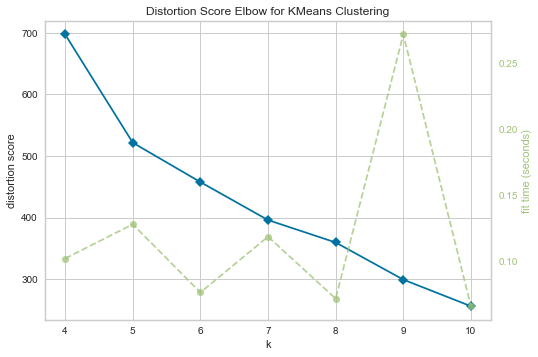

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [83]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

#tokyo_part_clustering_borough = tokyo_grouped_borough.drop('Borough', 1)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,11), locate_elbow=False)

visualizer.fit(tokyo_part_clustering_borough)        # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

From the plot up here, the best k value seems to be 6.

Run _k_-means to cluster the neighborhood into 6 clusters.

In [84]:
# set number of clusters
kclusters = 6

tokyo_grouped_clustering_borough = tokyo_grouped_borough.drop('Borough', 1)

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering)
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering_borough)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 0, 1, 5, 0, 0, 0, 3, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [85]:
tokyo_merged_borough = covid_foreign_bar.copy()

# add clustering labels
tokyo_merged_borough.insert(0, 'Cluster Labels', kmeans.labels_)

# merge neighborhoods with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
#tokyo_merged = tokyo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
#tokyo_merged = tokyo_merged.join(tokyo_venues_bar_count.set_index('Neighborhood'), on='Neighborhood')

print(tokyo_merged_borough.shape)
tokyo_merged_borough.head() # check the last columns!

(57, 35)


,Cluster Labels,Municipal_code,Borough_J,COVID_positive,Borough,Borough_suffix,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others,Latitude,Longitude,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
0,4,13101,千代田区,601,Chiyoda,ku,2996,1250,455,76,64,24,194,210,79,16,46,582,35.693810,139.753216,55.0,8.0,9.0,0.0,2.0,0.0,0.0,3.0,2.0,0.0,22.0,0.0,0.0,1.0,8.0
1,0,13102,中央区,1828,Chuo,ku,7651,3266,1401,192,153,95,385,391,275,38,89,1366,35.666255,139.775565,37.0,7.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,14.0,0.0,0.0,1.0,9.0
2,1,13103,港区,3792,Minato,ku,20057,3962,3461,144,1027,107,756,3257,649,56,191,6447,35.643227,139.740055,59.0,13.0,7.0,1.0,3.0,0.0,0.0,3.0,2.0,1.0,25.0,0.0,0.0,1.0,3.0
3,5,13104,新宿区,6551,Shinjuku,ku,43068,14153,10221,3484,747,3517,1884,1033,246,2218,735,4830,35.693763,139.703632,40.0,8.0,8.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,19.0,0.0,0.0,0.0,2.0
4,0,13105,文京区,1688,Bunkyo,ku,10808,4646,1658,927,223,364,509,329,107,317,192,1536,35.718810,139.744732,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


#### View COVID Clusters

Finally, let's visualize the resulting clusters


In [86]:
title = 'COVID19 cluster in Tokyo as of ' + covid_json_date
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(title) 
# create map
map_clusters_borough = folium.Map(location=[latitude, longitude], zoom_start=11)
map_clusters_borough.get_root().html.add_child(folium.Element(title_html))

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, b, cluster, covid in zip(tokyo_merged_borough['Latitude'], 
                                        tokyo_merged_borough['Longitude'], 
                                        tokyo_merged_borough['Borough'], 
                                        tokyo_merged_borough['Cluster Labels'], 
                                        tokyo_merged_borough['COVID_positive']):
    if np.isnan(cluster):
        color = '#ffffff'
        str_cluster = 'NaN'
    else:
        color = rainbow[int(cluster) - 1]
        str_cluster = str(int(cluster) + 1)        
    label = folium.Popup(str(b) + ', Cluster:' + str_cluster + ', COVID:' + str(covid), parse_html=True)
        
    folium.CircleMarker(
        [lat, lon],
        radius=5 if np.isnan(covid) else int(covid)/100,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters_borough)
       
map_clusters_borough

### Examine COVID Clusters



Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.


#### Cluster 1

In [87]:
tokyo_merged_borough.loc[tokyo_merged_borough['Cluster Labels'] == 0]

,Cluster Labels,Municipal_code,Borough_J,COVID_positive,Borough,Borough_suffix,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others,Latitude,Longitude,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
1,0,13102,中央区,1828,Chuo,ku,7651,3266,1401,192,153,95,385,391,275,38,89,1366,35.666255,139.775565,37.0,7.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,14.0,0.0,0.0,1.0,9.0
4,0,13105,文京区,1688,Bunkyo,ku,10808,4646,1658,927,223,364,509,329,107,317,192,1536,35.718810,139.744732,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
5,0,13106,台東区,2069,Taito,ku,15433,6489,3118,824,785,688,503,253,713,134,334,1592,35.717450,139.790859,19.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,13.0,0.0,0.0,0.0,0.0
6,0,13107,墨田区,2150,Sumida,ku,12645,5874,1966,679,1349,320,401,183,140,75,388,1270,35.700429,139.805017,27.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.0,0.0,0.0,0.0,0.0
8,0,13109,品川区,3251,Shinagawa,ku,13042,4317,2426,547,798,712,600,607,402,292,196,2145,35.599252,139.738910,46.0,11.0,6.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,24.0,0.0,1.0,0.0,1.0
9,0,13110,目黒区,3053,Meguro,ku,9102,1836,1498,202,537,252,469,979,198,54,165,2912,35.621250,139.688014,24.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,2.0,1.0
12,0,13113,渋谷区,3315,Shibuya,ku,10639,2013,1608,352,334,172,621,1383,177,57,168,3754,35.664596,139.698711,28.0,8.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,1.0,3.0
23,0,13201,八王子市,2300,Hachioji,shi,12936,4838,1815,1002,1360,592,311,302,153,94,193,2276,35.655389,139.339467,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [88]:
tokyo_merged_borough.loc[tokyo_merged_borough['Cluster Labels'] == 0].describe()

,Cluster Labels,Municipal_code,COVID_positive,FR_total,FR_Rep_of_Korea,FR_Philippines,Latitude,Longitude,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
count,8.0,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.0,8.000000,8.0,8.000000,8.000000,8.000000,8.0,8.000000,8.0,8.000000,8.000000,8.000000
mean,0.0,13119.125000,2456.750000,11532.000000,1936.250000,692.375000,35.667929,139.697659,23.500000,4.750000,2.37500,0.0,0.875000,0.0,0.125000,0.375000,0.500000,0.0,11.875000,0.0,0.375000,0.500000,1.750000
std,0.0,33.249866,652.277275,2478.380001,575.164759,472.142211,0.043366,0.150520,14.842025,3.918819,1.92261,0.0,1.246423,0.0,0.353553,0.744024,0.534522,0.0,7.845608,0.0,0.517549,0.755929,3.105295
min,0.0,13102.000000,1688.000000,7651.000000,1401.000000,153.000000,35.599252,139.339467,3.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.0,13105.750000,2008.750000,10254.750000,1580.500000,306.250000,35.646854,139.696037,15.250000,1.000000,1.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,7.750000,0.0,0.000000,0.000000,0.000000
50%,0.0,13108.000000,2225.000000,11726.500000,1736.500000,661.000000,35.665425,139.741821,25.500000,5.000000,2.00000,0.0,0.000000,0.0,0.000000,0.000000,0.500000,0.0,12.000000,0.0,0.000000,0.000000,0.500000
75%,0.0,13110.750000,3102.500000,12962.500000,2081.000000,935.750000,35.704684,139.779388,30.250000,7.250000,3.25000,0.0,2.000000,0.0,0.000000,0.250000,1.000000,0.0,15.500000,0.0,1.000000,1.000000,1.500000
max,0.0,13201.000000,3315.000000,15433.000000,3118.000000,1360.000000,35.718810,139.805017,46.000000,11.000000,6.00000,0.0,3.000000,0.0,1.000000,2.000000,1.000000,0.0,24.000000,0.0,1.000000,2.000000,9.000000


#### Cluster 2

In [89]:
tokyo_merged_borough.loc[tokyo_merged_borough['Cluster Labels'] == 1]

,Cluster Labels,Municipal_code,Borough_J,COVID_positive,Borough,Borough_suffix,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others,Latitude,Longitude,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
2,1,13103,港区,3792,Minato,ku,20057,3962,3461,144,1027,107,756,3257,649,56,191,6447,35.643227,139.740055,59.0,13.0,7.0,1.0,3.0,0.0,0.0,3.0,2.0,1.0,25.0,0.0,0.0,1.0,3.0
10,1,13111,大田区,5860,Ota,ku,24199,8467,3562,1494,2497,2287,1033,621,291,275,473,3199,35.561206,139.715843,16.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0,0.0,0.0,0.0
11,1,13112,世田谷区,8188,Setagaya,ku,21379,5835,4367,864,983,512,999,1706,503,129,260,5221,35.646096,139.656270,29.0,8.0,6.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,1.0
13,1,13114,中野区,3710,Nakano,ku,19326,6786,3365,1889,531,1750,970,496,127,471,272,2669,35.718123,139.664468,12.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,1.0
14,1,13115,杉並区,4442,Suginami,ku,17722,5837,2854,1486,546,2226,1009,750,92,196,240,2486,35.699493,139.636288,28.0,5.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,19.0,0.0,1.0,0.0,0.0
16,1,13117,北区,2448,Kita,ku,22621,10759,2432,2008,863,1342,565,247,194,1038,190,2983,35.755838,139.736687,28.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,1.0,0.0
17,1,13118,荒川区,1756,Arakawa,ku,19131,7284,5046,2075,528,1171,360,182,101,520,149,1715,35.737529,139.781310,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0
19,1,13120,練馬区,4828,Nerima,ku,19653,8177,4286,878,1099,690,827,527,120,164,290,2595,35.748360,139.638735,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
21,1,13122,葛飾区,3968,Katsushika,ku,21849,11322,3133,1076,1631,897,475,191,87,254,270,2513,35.751733,139.863816,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0


In [90]:
tokyo_merged_borough.loc[tokyo_merged_borough['Cluster Labels'] == 1].describe()

,Cluster Labels,Municipal_code,COVID_positive,FR_total,FR_Rep_of_Korea,FR_Philippines,Latitude,Longitude,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
count,9.0,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,1.0,13114.666667,4332.444444,20659.666667,3611.777778,1078.333333,35.695734,139.714830,22.555556,3.666667,1.888889,0.111111,0.333333,0.0,0.444444,0.333333,0.222222,0.111111,14.444444,0.111111,0.111111,0.222222,0.555556
std,0.0,5.656854,1886.062241,2013.318840,818.792675,638.591614,0.066237,0.075545,16.140873,4.358899,2.713137,0.333333,1.000000,0.0,0.726483,1.000000,0.666667,0.333333,7.055337,0.333333,0.333333,0.440959,1.013794
min,1.0,13103.000000,1756.000000,17722.000000,2432.000000,528.000000,35.561206,139.636288,6.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,13112.000000,3710.000000,19326.000000,3133.000000,546.000000,35.646096,139.656270,12.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,13115.000000,3968.000000,20057.000000,3461.000000,983.000000,35.718123,139.715843,16.000000,2.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,13118.000000,4828.000000,21849.000000,4286.000000,1099.000000,35.748360,139.740055,28.000000,5.000000,2.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,1.000000
max,1.0,13122.000000,8188.000000,24199.000000,5046.000000,2497.000000,35.755838,139.863816,59.000000,13.000000,7.000000,1.000000,3.000000,0.0,2.000000,3.000000,2.000000,1.000000,25.000000,1.000000,1.000000,1.000000,3.000000


#### Cluster 3

In [91]:
tokyo_merged_borough.loc[tokyo_merged_borough['Cluster Labels'] == 2]

,Cluster Labels,Municipal_code,Borough_J,COVID_positive,Borough,Borough_suffix,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others,Latitude,Longitude,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
27,2,13205,青梅市,559,Ome,shi,1877,363,211,283,416,33,81,63,8,3,55,361,35.803601,139.238128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,2,13215,国立市,280,Kunitachi,shi,1706,634,337,99,71,85,71,65,30,8,26,280,35.681991,139.436240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,2,13219,狛江市,395,Komae,shi,1312,483,187,66,111,90,42,51,20,7,38,217,35.634023,139.575977,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,2,13220,東大和市,323,Higashiyamato,shi,1157,404,193,38,245,23,26,23,5,3,25,172,35.740869,139.428831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,2,13221,清瀬市,264,Kiyose,shi,1262,435,152,97,205,62,47,32,1,7,26,198,35.785483,139.531253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,2,13222,東久留米市,440,Higashikurume,shi,2092,677,316,125,250,48,55,220,47,3,34,317,35.752546,139.519089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,2,13223,武蔵村山市,265,Musashimurayama,shi,1640,591,155,252,351,23,19,33,3,4,27,182,35.756509,139.385637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,2,13225,稲城市,366,Inagi,shi,1321,383,267,95,173,19,35,33,13,2,23,278,35.638229,139.507776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,2,13227,羽村市,254,Hamura,shi,1392,209,91,99,292,25,20,51,13,1,21,570,35.764833,139.307862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,2,13228,あきる野市,380,Akiruno,shi,839,130,107,181,127,7,22,59,2,1,19,184,35.731042,139.217028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
tokyo_merged_borough.loc[tokyo_merged_borough['Cluster Labels'] == 2].describe()

,Cluster Labels,Municipal_code,COVID_positive,FR_total,FR_Rep_of_Korea,FR_Philippines,Latitude,Longitude,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
count,18.0,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.000000,18.0,18.0,18.0,18.0
mean,2.0,13277.333333,209.722222,877.222222,120.055556,141.666667,34.963119,139.559388,0.388889,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277778,0.0,0.0,0.0,0.0
std,0.0,72.609350,181.012774,740.941099,112.171860,131.955875,2.095217,0.681899,1.243283,0.471405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.178511,0.0,0.0,0.0,0.0
min,2.0,13205.000000,3.000000,7.000000,2.000000,1.000000,27.094296,139.096172,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
25%,2.0,13221.250000,18.750000,87.250000,13.750000,16.500000,35.635075,139.255561,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
50%,2.0,13227.500000,259.000000,998.000000,99.000000,119.000000,35.734690,139.432536,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
75%,2.0,13307.750000,355.250000,1374.250000,191.500000,237.000000,35.758167,139.528212,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
max,2.0,13421.000000,559.000000,2092.000000,337.000000,416.000000,35.809660,142.191889,5.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000,0.0,0.0,0.0,0.0


#### Cluster 4

In [93]:
tokyo_merged_borough.loc[tokyo_merged_borough['Cluster Labels'] == 3]

,Cluster Labels,Municipal_code,Borough_J,COVID_positive,Borough,Borough_suffix,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others,Latitude,Longitude,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
7,3,13108,江東区,3575,Koto,ku,29472,14783,4557,1030,1585,583,703,467,2065,436,366,2897,35.649154,139.812790,37.0,5.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,1.0,0.0,2.0
15,3,13116,豊島区,2940,Toshima,ku,30223,12955,2545,3609,531,3439,1295,428,184,2232,286,2719,35.736156,139.714222,18.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,13.0,0.0,0.0,0.0,0.0
18,3,13119,板橋区,4126,Itabashi,ku,26759,14177,3218,1657,1545,1148,975,345,125,335,316,2918,35.774143,139.681209,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
20,3,13121,足立区,5225,Adachi,ku,31706,14001,7388,1554,3686,448,620,282,172,151,459,2945,35.783703,139.795319,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0
22,3,13123,江戸川区,4529,Edogawa,ku,35710,15424,4390,2580,2812,1197,738,352,4148,391,505,3173,35.678278,139.871091,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0


In [94]:
tokyo_merged_borough.loc[tokyo_merged_borough['Cluster Labels'] == 3].describe()

,Cluster Labels,Municipal_code,COVID_positive,FR_total,FR_Rep_of_Korea,FR_Philippines,Latitude,Longitude,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
count,5.0,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.0,5.000000,5.0,5.000000,5.0,5.000000,5.0,5.000000,5.0,5.000000
mean,3.0,13117.40000,4079.000000,30774.000000,4419.600000,2031.800000,35.724287,139.774926,15.600000,1.400000,1.000000,0.0,0.400000,0.0,0.200000,0.0,0.200000,0.0,11.800000,0.0,0.200000,0.0,0.400000
std,0.0,5.85662,875.979737,3292.102292,1856.685299,1228.219728,0.058988,0.076755,13.088163,2.073644,1.414214,0.0,0.547723,0.0,0.447214,0.0,0.447214,0.0,8.318654,0.0,0.447214,0.0,0.894427
min,3.0,13108.00000,2940.000000,26759.000000,2545.000000,531.000000,35.649154,139.681209,4.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.000000,0.0,0.000000,0.0,0.000000
25%,3.0,13116.00000,3575.000000,29472.000000,3218.000000,1545.000000,35.678278,139.714222,7.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,7.000000,0.0,0.000000,0.0,0.000000
50%,3.0,13119.00000,4126.000000,30223.000000,4390.000000,1585.000000,35.736156,139.795319,12.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,11.000000,0.0,0.000000,0.0,0.000000
75%,3.0,13121.00000,4529.000000,31706.000000,4557.000000,2812.000000,35.774143,139.812790,18.000000,1.000000,2.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,13.000000,0.0,0.000000,0.0,0.000000
max,3.0,13123.00000,5225.000000,35710.000000,7388.000000,3686.000000,35.783703,139.871091,37.000000,5.000000,3.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,25.000000,0.0,1.000000,0.0,2.000000


#### Cluster 5

In [95]:
tokyo_merged_borough.loc[tokyo_merged_borough['Cluster Labels'] == 4]

,Cluster Labels,Municipal_code,Borough_J,COVID_positive,Borough,Borough_suffix,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others,Latitude,Longitude,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
0,4,13101,千代田区,601,Chiyoda,ku,2996,1250,455,76,64,24,194,210,79,16,46,582,35.693810,139.753216,55.0,8.0,9.0,0.0,2.0,0.0,0.0,3.0,2.0,0.0,22.0,0.0,0.0,1.0,8.0
24,4,13202,立川市,856,Tachikawa,shi,4374,1928,754,209,396,179,118,130,47,9,51,553,35.724463,139.404766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,4,13203,武蔵野市,883,Musashino,shi,3240,1083,557,118,93,154,177,300,40,17,41,660,35.712898,139.563534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,4,13204,三鷹市,1103,Mitaka,shi,3813,1178,693,194,189,102,217,328,48,38,61,765,35.685227,139.572916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,4,13206,府中市,1197,Fuchu,shi,5302,1809,814,269,536,97,218,264,54,43,103,1095,35.661112,139.473445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,4,13207,昭島市,578,Akishima,shi,2688,697,500,279,376,251,46,70,66,14,29,360,35.702480,139.350065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,4,13208,調布市,1357,Chofu,shi,4629,1662,1032,232,294,74,218,158,63,55,96,745,35.660036,139.554815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,4,13209,町田市,1942,Machida,shi,6228,2421,936,412,572,111,177,221,75,21,109,1173,35.564193,139.442839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,4,13210,小金井市,598,Koganei,shi,2792,1160,296,143,134,134,87,201,23,27,64,523,35.704108,139.510676,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
33,4,13211,小平市,679,Kodaira,shi,5204,1758,1065,285,265,116,191,107,36,20,91,1270,35.725220,139.476606,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [96]:
tokyo_merged_borough.loc[tokyo_merged_borough['Cluster Labels'] == 4].describe()

,Cluster Labels,Municipal_code,COVID_positive,FR_total,FR_Rep_of_Korea,FR_Philippines,Latitude,Longitude,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
count,16.0,16.000000,16.000000,16.00000,16.000000,16.000000,16.000000,16.000000,16.000000,16.0,16.0000,16.0,16.000,16.0,16.0,16.0000,16.000,16.0,16.000000,16.0,16.0,16.0000,16.0
mean,4.0,13204.437500,850.312500,3797.62500,621.375000,282.437500,35.692691,139.486547,3.812500,0.5,0.5625,0.0,0.125,0.0,0.0,0.1875,0.125,0.0,1.750000,0.0,0.0,0.0625,0.5
std,0.0,28.537621,403.200813,1152.89808,266.091933,148.996183,0.048528,0.100803,13.668547,2.0,2.2500,0.0,0.500,0.0,0.0,0.7500,0.500,0.0,5.446712,0.0,0.0,0.2500,2.0
min,4.0,13101.000000,374.000000,2365.00000,234.000000,64.000000,35.564193,139.334682,0.000000,0.0,0.0000,0.0,0.000,0.0,0.0,0.0000,0.000,0.0,0.000000,0.0,0.0,0.0000,0.0
25%,4.0,13205.500000,593.000000,2817.50000,436.250000,175.250000,35.661102,139.435806,0.000000,0.0,0.0000,0.0,0.000,0.0,0.0,0.0000,0.000,0.0,0.000000,0.0,0.0,0.0000,0.0
50%,4.0,13209.500000,705.000000,3526.50000,528.500000,277.500000,35.703294,139.475026,0.000000,0.0,0.0000,0.0,0.000,0.0,0.0,0.0000,0.000,0.0,0.000000,0.0,0.0,0.0000,0.0
75%,4.0,13213.250000,1079.750000,4647.25000,835.250000,381.000000,35.724652,139.551375,1.000000,0.0,0.0000,0.0,0.000,0.0,0.0,0.0000,0.000,0.0,1.000000,0.0,0.0,0.0000,0.0
max,4.0,13229.000000,1942.000000,6228.00000,1065.000000,572.000000,35.768929,139.753216,55.000000,8.0,9.0000,0.0,2.000,0.0,0.0,3.0000,2.000,0.0,22.000000,0.0,0.0,1.0000,8.0


#### Cluster 6

In [97]:
tokyo_merged_borough.loc[tokyo_merged_borough['Cluster Labels'] == 5]

,Cluster Labels,Municipal_code,Borough_J,COVID_positive,Borough,Borough_suffix,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others,Latitude,Longitude,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
3,5,13104,新宿区,6551,Shinjuku,ku,43068,14153,10221,3484,747,3517,1884,1033,246,2218,735,4830,35.693763,139.703632,40.0,8.0,8.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,19.0,0.0,0.0,0.0,2.0


In [98]:
tokyo_merged_borough.loc[tokyo_merged_borough['Cluster Labels'] == 5].describe()

,Cluster Labels,Municipal_code,COVID_positive,FR_total,FR_Rep_of_Korea,FR_Philippines,Latitude,Longitude,Bar_total,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Dive Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Salon / Barbershop,Sports Bar,Whisky Bar,Wine Bar
count,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,5.0,13104.0,6551.0,43068.0,10221.0,747.0,35.693763,139.703632,40.0,8.0,8.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,19.0,0.0,0.0,0.0,2.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.0,13104.0,6551.0,43068.0,10221.0,747.0,35.693763,139.703632,40.0,8.0,8.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,19.0,0.0,0.0,0.0,2.0
25%,5.0,13104.0,6551.0,43068.0,10221.0,747.0,35.693763,139.703632,40.0,8.0,8.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,19.0,0.0,0.0,0.0,2.0
50%,5.0,13104.0,6551.0,43068.0,10221.0,747.0,35.693763,139.703632,40.0,8.0,8.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,19.0,0.0,0.0,0.0,2.0
75%,5.0,13104.0,6551.0,43068.0,10221.0,747.0,35.693763,139.703632,40.0,8.0,8.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,19.0,0.0,0.0,0.0,2.0
max,5.0,13104.0,6551.0,43068.0,10221.0,747.0,35.693763,139.703632,40.0,8.0,8.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,19.0,0.0,0.0,0.0,2.0


-------------------

## Results and Discussion <a name="results"></a>


#### 1. Analysis Neighborhood bars

Neighborhood cluster view is a cluster created only by the neighborhood bar type. It is possible to grasp the atmosphere of the city by the type of bar.

 - Cluster 1: 
   - Neigborhood has many expensive bars, and the number of bars is 11 or less.
 - Cluster 2:
   - There are many sake bars in the neighborhood, which is often found in downtown, and the number of bars is 19 or less.
 - Cluster 3:
   - Neigborhood has many expensive bars, and the number of bars is 8 or less.
 - Cluster 4:
   - There are few neighborhoods in downtown and many in the city center, and there are many neighborhoods and bars.
 - Cluster 5:
   - Luxury residential area

#### 2. Analysis COVID positive, Foreign Residents and bars per Borough

 | Cluster | COVID_positive mean | FR_total mean | Bar_total mean |
 |---------|--------------------:|--------------:|---------------:|
 |  1      |   2451.25           | 11532.00      | 23.50          |
 |  2      |   4321.88           | 20659.66      | 22.55          |
 |  3      |    208.44           |   877.22      |  0.38          |
 |  4      |   4065.00           | 30774.00      | 15.60          |
 |  5      |    846.87           |  3797.62      |  3.81          |
 |  6      |   6534.00           | 43068.00      | 40.00          |


 - Cluster 1: 
   - The number of infected people is relatively small in the city center or in some exceptional suburbs.
 - Cluster 2:
   - It is a cluster with Setagaya Ward, which has the highest number of infected people, and there are many bars and foreign residents.
 - Cluster 3:
   - Suburban clusters with the fewest bars and foreign residents and the least infected
 - Cluster 4:
   - Boroughs with many foreign residents, bars and many infected people in downtown
 - Cluster 5:
   - Suburban clusters with few bars and foreign residents and few infected
 - Cluster 6:
   - Borough only in Shinjuku Ward, there are many bars, the number of foreign residents is the largest, and the second most infected.




-------------------

## Conclusion <a name="conclusion"></a>

The problem was to answer the question of what kind of city is a city with many COVID-19 infected people.
It could be illustrated by clustering the features of Neigborhood according to the type of bar.
Furthermore, Borough could be clustered and illustrated according to the number of foreign residents, the number of bars, and the number of COVID-19 infected persons. It can be speculated that Borough, which belongs to a cluster with a large number of infected people, may be susceptible to infection.

#### Future research
The following can be considered as the continuation of future research.
  - The number of foreign residents is from 2019, so it cannot be said that it is valid data. If available, you should investigate with the latest data.
  - It is natural that there are few infected people in areas with a small population and areas with a low population density. The analysis should also take into account the population and population density.
  - In addition to foreign residents, the movement of immigrants and people from overseas should be considered as statistical values.